In [1]:
import pandas as pd
from shapely.geometry import Point # Shapely for converting latitude/longtitude to geometry
import geopandas as gpd # To create GeodataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
from datetime import datetime, timedelta
warnings.filterwarnings('ignore')

In [2]:
original_df = pd.read_csv('/work/trips.csv')
header_df = pd.read_csv('/work/TripBulkReportTripsHeaders.csv')
trips_df = pd.concat([original_df,header_df])

In [3]:
# code below is used for new data set of (May 25 & May 26)

# header = list(pd.read_csv('/work/TripBulkReportTripsHeaders.csv',keep_default_na=True))
# header.append('Unnamed 31')
# header.append('Unnamed 32')
# trips_df = pd.read_csv('/work/trips_new.csv', keep_default_na=True, names=header)

In [4]:
trips_df.head()

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MovementType,OriginCbg,DestCbg,StartTimezone,EndTimezone,WaypointFreqSec,StartQk,EndQk,Unnamed: 31,Unnamed: 32
0,a939d5d8c9b52b5265161bfa93054f0a,0006da8402c807c4be339cab03f9d498,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T20:19:31.000Z,3,2022-05-11T20:22:52.000Z,3,30.18252,-96.93443,...,1,NaN,NaN,America/Chicago,America/Chicago,NaN,2.313010e+16,2.313010e+16,NaN,NaN
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}"""
2,a4d0936eb3b45ff1a5af8885939fbcd5,011dbfd3e177545535328ba48377522f,74071a673307ca7459bcf75fbd024e09,0,2022-05-13T21:40:44.000Z,5,2022-05-13T21:48:42.000Z,5,38.75461,-104.78828,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""fused\""","\""aid_type\"":\""AAID\""}"""
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,NaN,NaN
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,1,NaN,NaN,America/Denver,America/Denver,NaN,2.310120e+16,2.310120e+16,"{\method\"":\""gps\""","\""aid_type\"":\""IDFA\""}"""


#  Data Cleaning

### 1. Make sure there are no duplicate rows &amp; Exclude data in TX

In [5]:
number_of_dup = len(trips_df[trips_df.duplicated(subset=list(trips_df.columns).remove('TripId')) == True])
number_of_fort = len(trips_df[(trips_df['OriginZoneName']!='Buc-ee\'s Giddings TX')& (trips_df['DestinationZoneName']!='Buc-ee\'s Giddings TX')])

print('Number of rows in original data:', len(trips_df))
print('Number of data in Fort Carson : ',number_of_fort)
print('Number of duplicated rows : ',number_of_dup)


Number of rows in original data: 136880
Number of data in Fort Carson :  134373
Number of duplicated rows :  0


### 2. Create geometry column

In [6]:
trips_df = trips_df[(trips_df['OriginZoneName']!='Buc-ee\'s Giddings TX')& (trips_df['DestinationZoneName']!='Buc-ee\'s Giddings TX')]
# creating a geometry column 
trips_df['Startlocation'] = list(zip(trips_df.StartLocLat, trips_df.StartLocLon))
trips_df['Startlocation'] = trips_df['Startlocation'].apply(Point)

trips_df['Endlocation'] = list(zip(trips_df.EndLocLat, trips_df.EndLocLon))
trips_df['Endlocation'] = trips_df['Endlocation'].apply(Point)


# Coordinate reference system : WGS84
crs = {'init': 'epsg:4326'}

# Creating a Geographic data frame 
gdf = gpd.GeoDataFrame(trips_df, crs=crs)


### 3. Deal with Datetime

In [7]:
gdf['MST_start_datetime'] = pd.to_datetime(gdf['StartDate']).apply(lambda x:x.astimezone('MST'))
gdf['MST_end_datetime'] = pd.to_datetime(gdf['EndDate']).apply(lambda x:x.astimezone('MST'))

gdf['MST_start_date'] = gdf['MST_start_datetime'].apply(lambda x:x.date())
gdf['MST_start_time'] = gdf['MST_start_datetime'].apply(lambda x:x.time())

gdf['MST_end_date'] = gdf['MST_end_datetime'].apply(lambda x:x.date())
gdf['MST_end_time'] = gdf['MST_end_datetime'].apply(lambda x:x.time())

In [8]:
# create df of start day, month, year 
startYear = list(pd.DatetimeIndex(gdf['MST_start_date']).year)
startMonth = list(pd.DatetimeIndex(gdf['MST_start_date']).month)
startDay = list(pd.DatetimeIndex(gdf['MST_start_date']).day)

# insert the start month, day, year column into the gdf
gdf.insert(int(gdf.columns.get_indexer(['MST_start_date'])[0]+1), 'MST_start_month',startMonth)
gdf.insert(int(gdf.columns.get_indexer(['MST_start_date'])[0]+2), 'MST_start_day',startDay)
gdf.insert(int(gdf.columns.get_indexer(['MST_start_date'])[0]+3), 'MST_start_year',startYear)

# create df of start hour, minutes, and seconds
startHour = list(pd.DatetimeIndex(gdf['MST_start_datetime']).hour)
startMin = list(pd.DatetimeIndex(gdf['MST_start_datetime']).minute)
startSec = list(pd.DatetimeIndex(gdf['MST_start_datetime']).second)

# insert the start hour, minutes, seconds column into the gdf
gdf.insert(int(gdf.columns.get_indexer(['MST_start_time'])[0]+1), 'MST_start_hour',startHour)
gdf.insert(int(gdf.columns.get_indexer(['MST_start_time'])[0]+2), 'MST_start_minute',startMin)
gdf.insert(int(gdf.columns.get_indexer(['MST_start_time'])[0]+3), 'MST_start_second',startSec)

# create df of end day, month, year 
endYear = list(pd.DatetimeIndex(gdf['MST_end_date']).year)
endMonth = list(pd.DatetimeIndex(gdf['MST_end_date']).month)
endDay = list(pd.DatetimeIndex(gdf['MST_end_date']).day)

# insert the start month, day, year column into the gdf
gdf.insert(int(gdf.columns.get_indexer(['MST_end_date'])[0]+1), 'MST_end_month',endMonth)
gdf.insert(int(gdf.columns.get_indexer(['MST_end_date'])[0]+2), 'MST_end_day',endDay)
gdf.insert(int(gdf.columns.get_indexer(['MST_end_date'])[0]+3), 'MST_end_year',endYear)

# create df of end hour, minutes, and seconds
endHour = list(pd.DatetimeIndex(gdf['MST_end_datetime']).hour)
endMin = list(pd.DatetimeIndex(gdf['MST_end_datetime']).minute)
endSec = list(pd.DatetimeIndex(gdf['MST_end_datetime']).second)

# insert the start hour, minutes, seconds column into the gdf
gdf.insert(int(gdf.columns.get_indexer(['MST_end_time'])[0]+1), 'MST_end_hour',endHour)
gdf.insert(int(gdf.columns.get_indexer(['MST_end_time'])[0]+2), 'MST_end_minute',endMin)
gdf.insert(int(gdf.columns.get_indexer(['MST_end_time'])[0]+3), 'MST_end_second',endSec)


### 4.Exclude data whose ProviderType == Fleet

[Text(0, 0, '125367'), Text(0, 0, '9006')]

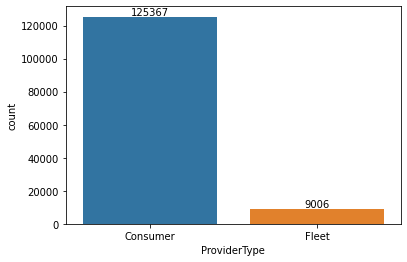

In [9]:
provider_type = sns.countplot(trips_df['ProviderType'])
provider_type.set_xticklabels(['Consumer','Fleet'])
provider_type.bar_label(provider_type.containers[0])

In [10]:
# exclude data whose ProviderType == Fleet
gdf = gdf[gdf['ProviderType']==1] 
gdf.head()

,TripId,DeviceId,ProviderId,Mode,StartDate,StartWDay,EndDate,EndWDay,StartLocLat,StartLocLon,...,MST_start_minute,MST_start_second,MST_end_date,MST_end_month,MST_end_day,MST_end_year,MST_end_time,MST_end_hour,MST_end_minute,MST_end_second
1,88180c2feb14c8520f169e4bda526313,009ef4b15eadd773468cd2bfdff6eb54,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T21:07:54.000Z,6,2022-05-14T21:58:03.000Z,6,38.27969,-104.52873,...,7,54,2022-05-14,5,14,2022,14:58:03,14,58,3
2,a4d0936eb3b45ff1a5af8885939fbcd5,011dbfd3e177545535328ba48377522f,74071a673307ca7459bcf75fbd024e09,0,2022-05-13T21:40:44.000Z,5,2022-05-13T21:48:42.000Z,5,38.75461,-104.78828,...,40,44,2022-05-13,5,13,2022,14:48:42,14,48,42
3,a04c70dd5a17f8f54b7a5576951da0c5,014b33b72b76a3ba8cbb621009408974,d07e70efcfab08731a97e7b91be644de,1,2022-05-11T23:37:31.000Z,3,2022-05-11T23:47:49.000Z,3,38.67639,-104.70588,...,37,31,2022-05-11,5,11,2022,16:47:49,16,47,49
4,509bba65db0e6495bb35e615f823350c,014ed4fc9ea19b744e0eb3a0b1d72bb1,74071a673307ca7459bcf75fbd024e09,1,2022-05-12T00:14:40.000Z,3,2022-05-12T00:37:38.000Z,3,38.55622,-104.64958,...,14,40,2022-05-11,5,11,2022,17:37:38,17,37,38
5,331d214470e8b35cbd9a4fff41e857ec,018c8710f851218ae510a49e8bbdee56,74071a673307ca7459bcf75fbd024e09,1,2022-05-14T20:10:10.000Z,6,2022-05-14T21:33:25.000Z,6,38.34111,-104.66880,...,10,10,2022-05-14,5,14,2022,14:33:25,14,33,25


In [11]:
gdf.to_csv('/work/trips_after_cleaning.csv')

# EDA 

### 1. Number of Device

In [12]:
gdf = pd.read_csv('/work/trips_after_cleaning.csv')
device_number = len(gdf['DeviceId'].unique())
print('These {} trips are from {} unique devices.'.format(len(gdf),device_number))

These 125367 trips are from 65890 unique devices.


### 2. Walk vs. Vehicle

[Text(0, 0, '7784'), Text(0, 0, '114747'), Text(0, 0, '2836')]

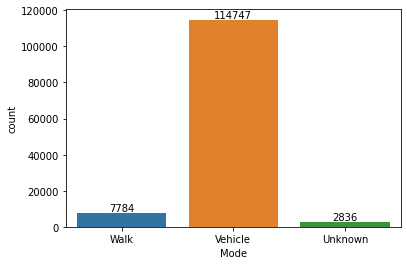

In [13]:
count_plot = sns.countplot(gdf['Mode'])
count_plot.set_xticklabels(['Walk','Vehicle','Unknown']) 
count_plot.bar_label(count_plot.containers[0])

### 3. Vehicle type

[Text(0, 0, '49851'), Text(0, 0, '75516')]

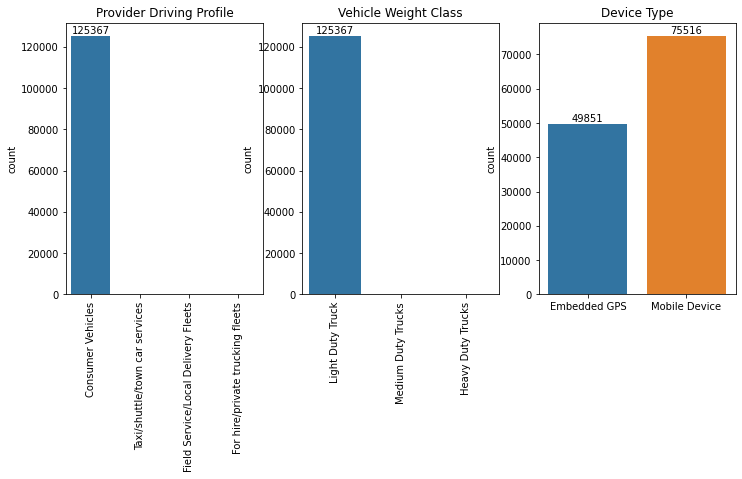

In [14]:
fig,[ax1,ax2,ax3] = plt.subplots(nrows=1, ncols=3,figsize=(12,5))
sns.countplot(gdf['ProviderDrivingProfile'],ax=ax1,order=[1,2,3,4])
title1='Provider Driving Profile' 
ax1.set_title(title1)
ax1.set_xticklabels(['Consumer Vehicles','Taxi/shuttle/town car services','Field Service/Local Delivery Fleets','For hire/private trucking fleets'],rotation=90) 
ax1.set(xlabel=None)
ax1.bar_label(ax1.containers[0])

sns.countplot(gdf['VehicleWeightClass'],ax=ax2,order=[1,2,3])
title2 = 'Vehicle Weight Class' 
ax2.set_title(title2)
ax2.set_xticklabels(['Light Duty Truck','Medium Duty Trucks','Heavy Duty Trucks'],rotation=90)
ax2.set(xlabel=None)
ax2.bar_label(ax2.containers[0])

sns.countplot(gdf['ProbeSourceType'],ax=ax3)
ax3.set_title('Device Type')
ax3.set_xticklabels(['Embedded GPS','Mobile Device'])
ax3.set(xlabel=None)
ax3.bar_label(ax3.containers[0])

### 4.Trips per Device

In [15]:
gdf.groupby('DeviceId').count()['TripId'].sort_values(ascending=False)

DeviceId
70e68ce6b66dd2052c188f2bd8ad0563    91
c6d52211ec83fb63badb38f323b9544e    87
b4ff8360a3e7ac8fa763580f3202936f    84
7ebcf69bfbf7b47abab7ef0db2a72f08    73
0f38377b674a05d3e686a692b1ad0571    73
                                    ..
5c74e85b99cb5f281355a6082a5e719b     1
5c7869cf018376e328bd37c307ade182     1
5c7c47733c412a7e23b80df65ebc70d5     1
5c7e0c3d9bf2f1168c31fc4cb066d844     1
fffea5a18f1a308cee147a3e9c726700     1
Name: TripId, Length: 65890, dtype: int64

##### On average, during the month of May each device visits Fort Carson 1.76 times. 

In [16]:
# Calculate mean number of trips per deviceId
mean_frequency = gdf.groupby(by = ["Mode","DeviceId"]).count()['TripId'].mean()
print('During the month of May, on average each device frequents Fort Carson ' + str(mean_frequency) + ' times.')


During the month of May, on average each device frequents Fort Carson 1.7801238179081589 times.


In [17]:
top_100_device_frequency = gdf['DeviceId'].value_counts().nlargest(1000)

print('Top 1000 most frequent deviceIds in May, 2022:\n' ,top_100_device_frequency)

Top 1000 most frequent deviceIds in May, 2022:
 70e68ce6b66dd2052c188f2bd8ad0563    91
c6d52211ec83fb63badb38f323b9544e    87
b4ff8360a3e7ac8fa763580f3202936f    84
7ebcf69bfbf7b47abab7ef0db2a72f08    73
0f38377b674a05d3e686a692b1ad0571    73
                                    ..
b93172855031d35a2de8daa35ccad7c2    16
0847f30605dc40e4381b097e5bc30db5    16
85da6a2d19f9f59cdef120b2f5d9d1fe    16
b94883fac37f1ae6863db16076a9b561    16
bc57d1b695cfb96ac1511713b1ae4356    16
Name: DeviceId, Length: 1000, dtype: int64


70e68ce6b66dd2052c188f2bd8ad0563    91
c6d52211ec83fb63badb38f323b9544e    87
b4ff8360a3e7ac8fa763580f3202936f    84
7ebcf69bfbf7b47abab7ef0db2a72f08    73
0f38377b674a05d3e686a692b1ad0571    73
fdb8335a86289cc02c878d534acc64d6    72
3de0769d66ec0c1d5af1c6932a7cb11b    69
4463db876cfb9492daaac5b440b07e8c    69
12442b4a8ce203b9691b4c75ec448568    67
7f9a222ec5dabd2c4e3a5ad18015a8e3    66
Name: DeviceId, dtype: int64

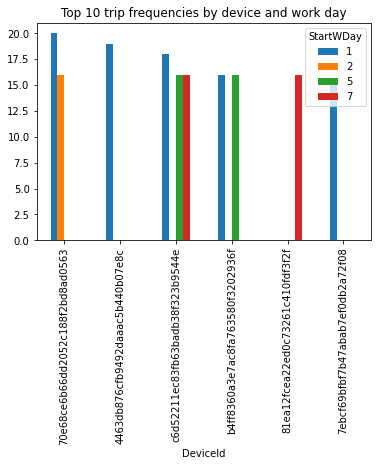

In [18]:
top_10_device_frequency_by_day = gdf.groupby(["StartWDay",'DeviceId']).count()['TripId'].nlargest(10).unstack(0).plot.bar(title = 'Top 10 trip frequencies by device and work day')
top_10_device_frequency_by_day = gdf['DeviceId'].value_counts().nlargest(10)
top_10_device_frequency_by_day


In [19]:
# Plot top 10 trip frequency based on hour and deviceId
device_by_hour = gdf.groupby(['Mode','DeviceId','MST_start_hour']).count()['TripId'].nlargest(10)
device_by_hour

Mode  DeviceId                          MST_start_hour
1     27f1ed72366fed2785ed61872bebd591  4                 12
      b329d24cce75151cf90c59d3496a6376  8                 12
      08e349a7568e0b3438b6389f6b09be2b  10                11
      a1b6f3ef1acd4d92a0e5d842d18cfcea  11                11
      a2b605e269966e8045debd0c07fcf339  7                 11
      fc300205a2b6928df2c24354c0215426  5                 11
      fdb8335a86289cc02c878d534acc64d6  11                11
      06b1fe61ea89c343ac60b3e582a1ca1c  5                 10
      08e349a7568e0b3438b6389f6b09be2b  8                 10
      0b4b497a3d93421ef76916d00fd3ef3c  8                 10
Name: TripId, dtype: int64

### 5.Trip Length

In [20]:
trip_length = pd.to_datetime(gdf['MST_end_datetime'])-pd.to_datetime(gdf['MST_start_datetime'])

days, seconds = trip_length.apply(lambda x:x.days), trip_length.apply(lambda x:x.seconds)
hours = days * 24 + seconds // 3600

trip_length_minutes = (pd.to_datetime(gdf['MST_end_datetime'])-pd.to_datetime(gdf['MST_start_datetime'])).apply(lambda x:x.seconds//60)

Text(0.5, 0, 'trip length (minutes)')

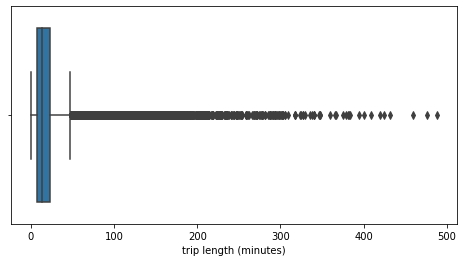

In [21]:
plt.figure(figsize=(8,4))
sns.boxplot(trip_length_minutes)
plt.xlabel('trip length (minutes)')

### 6. Number of trips within vs. to vs. from Fort Carson

[Text(0, 0, '37394'), Text(0, 0, '50641'), Text(0, 0, '37332')]

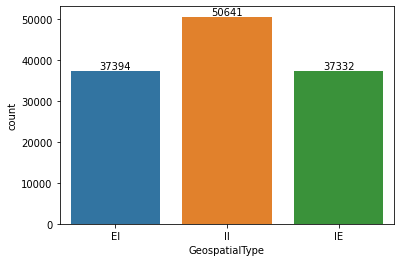

In [22]:
ax = sns.countplot(gdf['GeospatialType'])
ax.bar_label(ax.containers[0])

### 7.How often did they visit the facility?

##### To analyze the pattern of consumer visits to the facility, we have constructed bar charts of trips taken and grouped by day of the week for each trip type. 

##### From the chart, we can see that vehicle is the most common mode of transportation and most consumers visit the facility on Monday, Tuesday, Wednesday, and Friday

### Bar chart of trips available by day (for each trip type)

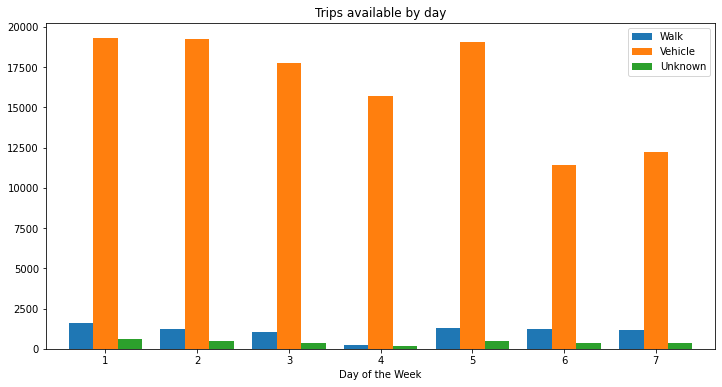

In [23]:
# Plotting bar chart for trips available by day (for each trip type)
index = ['Walk', 'Vehicle', 'Unknown']
ticks = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
trip_type = gdf.groupby(by = ["Mode","StartWDay"]).count()['TripId'].unstack(0).plot.bar(figsize=(12, 6), width=0.8, linewidth=0.2, title='Trips available by day', rot=0, xlabel="Day of the Week") 
trip_type.legend(index)

##### Next, for each trip type we look at trips taken by hour of the day and found that between 5:00 am and 5:00 pm MST. 

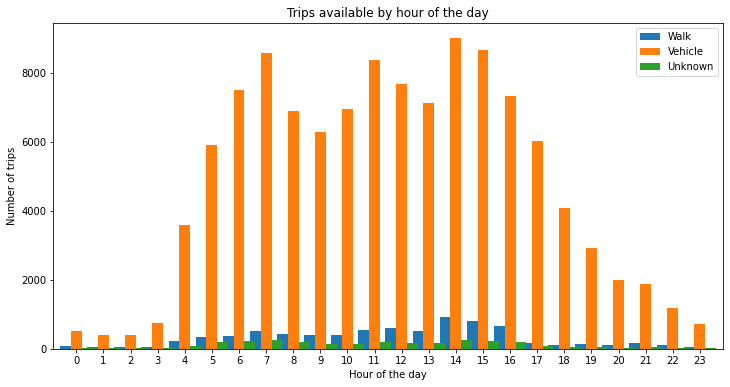

In [24]:
# Plot bar chart of trips available by hour of the day (for each trip type)
trip_by_hour = gdf.groupby(by=['Mode','MST_start_hour']).count()['TripId'].unstack(0).plot.bar(width = 1.2,title='Trips available by hour of the day', xlabel='Hour of the day',
ylabel='Number of trips',rot = 0, figsize=(12, 6))
trip_by_hour.legend(index)

<AxesSubplot:xlabel='StartWDay', ylabel='count'>

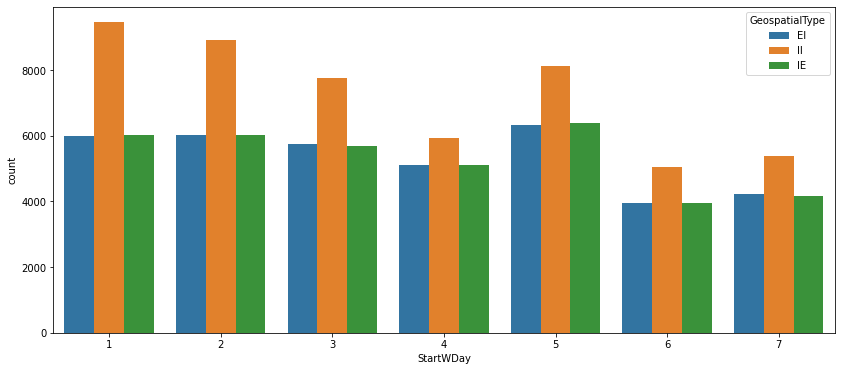

In [25]:
plt.figure(figsize=(14,6))
sns.countplot(gdf['StartWDay'],hue=gdf['GeospatialType'])


##### We have also visualized the distribution of IE,II, EI by the hour.
##### Assuming that most trips coming on to the base are of EI geospacial type and most trips coming off are of IE type, we can see that the most devices coming off the base occurs at 6am-7am. 

##### Assuming that most trips leaving the base are IE type, we can see that most trips/people leave Fort Carson beteween 2-3pm.




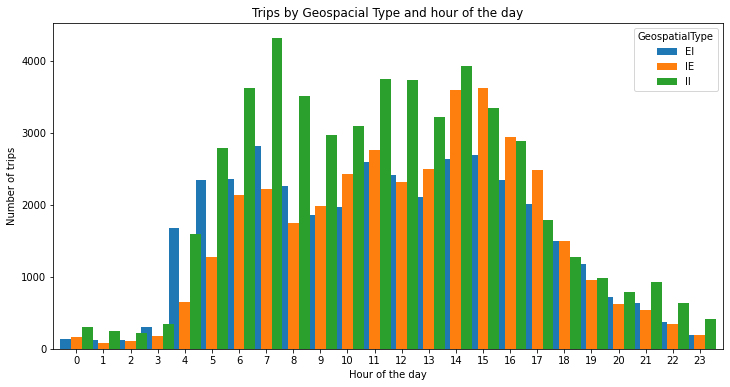

In [26]:
geospacial_by_hour = gdf.groupby(by=['GeospatialType','MST_start_hour']).count()['TripId'].unstack(0).plot.bar(width = 1.2,title='Trips by Geospacial Type and hour of the day', xlabel='Hour of the day',
ylabel='Number of trips',rot = 0, figsize=(12, 6))

In [27]:
# geospacial_by_hour = gdf.groupby(by=['GeospatialType','Mode']).count()['TripId'].unstack(0).plot.bar(width = 1.2,title='Trips by Geospacial Type and hour of the day', xlabel='Hour of the day',
# ylabel='Number of trips',rot = 0, figsize=(12, 6))

### 8.How long did they stay in the facility?

<AxesSubplot:xlabel='length_minutes'>

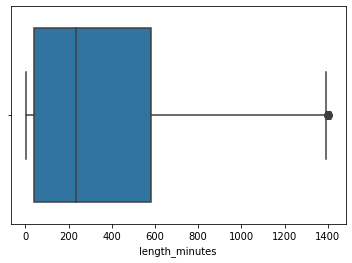

In [28]:
stay_length_df = pd.read_csv('/work/trips_duration.csv')
sns.boxplot(stay_length_df['length_minutes'])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=9863cd21-6747-4678-bbdd-813e8a94296e' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>